In [1]:
import pandas as pd, numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from scipy.stats.mstats import winsorize
from sklearn.metrics import *
from sklearn.ensemble import RandomForestRegressor

In [2]:
train = pd.read_csv("data/train.csv")
test = pd.read_csv("data/test.csv")

In [3]:
train.head(3)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500


In [4]:
train.shape, test.shape

((1460, 81), (1459, 80))

In [5]:
min(train["SalePrice"]), max(train["SalePrice"])

(34900, 755000)

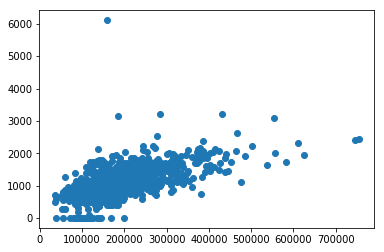

In [6]:
plt.scatter(train["SalePrice"], train["TotalBsmtSF"])
plt.show()

### Selecting only important variables and fitting Sale Price on these variables

In [7]:
variables = ["OverallQual", "MSSubClass","TotalBsmtSF","GrLivArea","SalePrice"]

In [8]:
train = train[variables]
Id = test["Id"]
test = test[["OverallQual", "MSSubClass","TotalBsmtSF","GrLivArea"]]

In [9]:
test.isna().sum()

OverallQual    0
MSSubClass     0
TotalBsmtSF    1
GrLivArea      0
dtype: int64

In [10]:
min(test["TotalBsmtSF"])

0.0

In [11]:
test.fillna(0, inplace=True)

In [12]:
train.head(3)

,OverallQual,MSSubClass,TotalBsmtSF,GrLivArea,SalePrice
0,7,60,856,1710,208500
1,6,20,1262,1262,181500
2,7,60,920,1786,223500


### Transformation

In [13]:
y = train["SalePrice"]
x = train.drop(["SalePrice"], axis = 1)

In [14]:
y_log = np.log(y)

In [59]:
y_win = winsorize(y, {0.025,0.95})

In [60]:
lr = LinearRegression()
lr.fit(x,y)
y_pred = lr.predict(test)

In [61]:
lr = LinearRegression()
lr.fit(x,y_log)
y_pred_log = np.exp(lr.predict(test))

In [62]:
lr = LinearRegression()
lr.fit(x,y_win)
y_pred_win = lr.predict(test)

In [63]:
submit1 = pd.DataFrame({"Id":Id, "SalePrice": y_pred})
submit2 = pd.DataFrame({"Id":Id, "SalePrice": y_pred_log})
submit3 = pd.DataFrame({"Id":Id, "SalePrice": y_pred_win})

In [64]:
submit1.to_csv("submit1.csv", index=None)
submit2.to_csv("submit2.csv", index=None)
submit3.to_csv("submit3.csv", index=None)

### Remove Outliers & Fit

#### IQR

In [21]:
q1 = np.percentile(train["SalePrice"],25)
q3 = np.percentile(train["SalePrice"],75)
iqr = q3-q1
upper = q3+1.5*iqr
lower = q1-1.5*iqr
lower, upper

(3937.5, 340037.5)

In [22]:
train_iqr = train[(train["SalePrice"]<upper) & (train["SalePrice"]>lower)]

In [23]:
train_iqr.shape

(1399, 5)

In [24]:
y = train_iqr["SalePrice"]
x = train_iqr.drop(["SalePrice"], axis = 1)
lr = LinearRegression()
lr.fit(x,y)
y_pred = lr.predict(test)

In [25]:
submit1 = pd.DataFrame({"Id":Id, "SalePrice": y_pred})
submit1.to_csv("submit_iqr.csv", index=None)

#### Z-Score

In [26]:
train = pd.read_csv("data/train.csv")
train = train[variables]

In [27]:
z = (train["SalePrice"] - np.mean(train["SalePrice"]))/np.std(train["SalePrice"])
train_z = train[(np.absolute(z)<2.5)]

In [28]:
y = train_z["SalePrice"]
x = train_z.drop(["SalePrice"], axis = 1)
lr = LinearRegression()
lr.fit(x,y)
y_pred = lr.predict(test)

In [29]:
submit1 = pd.DataFrame({"Id":Id, "SalePrice": y_pred})
submit1.to_csv("submit_z.csv", index=None)

### Random Forest

In [42]:
train = pd.read_csv("data/train.csv")
train = train[variables]

In [43]:
y = train["SalePrice"]
x = train.drop(["SalePrice"], axis = 1)
rf = RandomForestRegressor()
rf.fit(x,y)
y_pred = rf.predict(test)

In [44]:
submit1 = pd.DataFrame({"Id":Id, "SalePrice": y_pred})
submit1.to_csv("submit_rf_1.csv", index=None)

In [45]:
train_iqr = train[(train["SalePrice"]<upper) & (train["SalePrice"]>lower)]

In [46]:
y = train_iqr["SalePrice"]
x = train_iqr.drop(["SalePrice"], axis = 1)
rf.fit(x,y)
y_pred = rf.predict(test)

In [47]:
submit1 = pd.DataFrame({"Id":Id, "SalePrice": y_pred})
submit1.to_csv("submit_rf_iqr.csv", index=None)

In [48]:
y = train["SalePrice"]
x = train.drop(["SalePrice"], axis = 1)
y_log = np.log(y)
rf.fit(x,y_log)
y_pred_log = np.exp(rf.predict(test))

In [49]:
submit1 = pd.DataFrame({"Id":Id, "SalePrice": y_pred_log})
submit1.to_csv("submit_rf_log.csv", index=None)

In [50]:
y = train["SalePrice"]
x = train.drop(["SalePrice"], axis = 1)
rf = RandomForestRegressor(criterion='mae')
rf.fit(x,y)
y_pred = rf.predict(test)

In [51]:
submit1 = pd.DataFrame({"Id":Id, "SalePrice": y_pred})
submit1.to_csv("submit_rf_mae.csv", index=None)

In [54]:
y = train["SalePrice"]
x = train.drop(["SalePrice"], axis = 1)
y_win = winsorize(y, {0.025,0.95})
rf = RandomForestRegressor()
rf.fit(x,y_win)
y_pred = rf.predict(test)

In [55]:
submit1 = pd.DataFrame({"Id":Id, "SalePrice": y_pred})
submit1.to_csv("submit_rf_win.csv", index=None)